In [320]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import os
from tqdm import tqdm

df = pd.read_csv("../../data/data/train-metadata.csv", low_memory=False)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head)
benign = df[df['target'] == 0]
malignant  = df[df['target'] == 1]
    
benign_sampled = benign.sample(n=3000, random_state=42)
subset_df = pd.concat([benign_sampled, malignant ])
    
print(f"Class 0 samples: {len(benign_sampled)}")
print(f"Class 1 samples: {len(malignant )}")
print(f"Total samples: {len(subset_df)}")

<bound method NDFrame.head of              isic_id  target  patient_id  age_approx     sex  \
0       ISIC_6973879       0  IP_3201881        55.0  female   
1       ISIC_5407194       0  IP_5714646        40.0    male   
2       ISIC_5273739       0  IP_6391213        85.0    male   
3       ISIC_0802250       0  IP_6611217        55.0    male   
4       ISIC_8084953       0  IP_6957489        70.0    male   
...              ...     ...         ...         ...     ...   
401054  ISIC_6502755       0  IP_7965642        60.0    male   
401055  ISIC_9129069       0  IP_2889176        45.0  female   
401056  ISIC_3342513       0  IP_9577633        50.0    male   
401057  ISIC_3720179       0  IP_3751225        75.0    male   
401058  ISIC_3097113       0  IP_2573038        50.0    male   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
0          lower extremity                    3.15  TBP tile: close-up   
1          posterior torso                    3.03  T

In [321]:
missing_percentages = (subset_df.isnull().sum() / len(subset_df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = subset_df[columns_to_keep]

features_to_drop = [
    'iddx_full',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'patient_id',
    'lesion_id',
    'attribution',
    'copyright_license'
]

# We do this because depending on the seed and shuffle, the columns that get dropped will be different!
for col in features_to_drop:
    if col in skin_cancer_df.columns:
        print(f"Dropping column: {col}")
        skin_cancer_df = skin_cancer_df.drop(columns=[col])

numeric_columns = skin_cancer_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object', 'category']).columns

skin_cancer_df[numeric_columns] = skin_cancer_df[numeric_columns].fillna(
    skin_cancer_df[numeric_columns].median())
skin_cancer_df[categorical_columns] = skin_cancer_df[categorical_columns].fillna(
    skin_cancer_df[categorical_columns].mode().iloc[0])

Dropping column: iddx_full
Dropping column: iddx_1
Dropping column: patient_id
Dropping column: attribution
Dropping column: copyright_license


In [322]:
for col in categorical_columns:
    if col != 'isic_id':
        le = LabelEncoder()
        skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

In [ ]:
expected_samples = len(skin_cancer_df)
image_features = np.zeros((expected_samples, 128 * 128 * 3))
valid_indices = []

for idx, isic_id in tqdm(enumerate(skin_cancer_df['isic_id']), total=expected_samples):
    try:
        file_path = os.path.join("../../data/data/train-image/image", f"{isic_id}.jpg")
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            img_resized = np.array(Image.fromarray(img).resize((128, 128)))
            image_features[idx] = img_resized.reshape(-1)
            valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing {isic_id}: {str(e)}")
        continue

if not valid_indices:
    raise ValueError("No valid images were processed")

image_features = image_features[valid_indices]

100%|██████████| 3393/3393 [00:27<00:00, 124.10it/s]


In [324]:
image_features_scaled = image_features / 255.0
n_components = 150
pca = PCA(n_components=n_components, random_state=42)
image_features_pca = pca.fit_transform(image_features_scaled)

pca_columns = [f'pca_{i}' for i in range(n_components)]
image_df = pd.DataFrame(image_features_pca, columns=pca_columns)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nVariance explained by {n_components} components: {explained_variance[-1]}")


Variance explained by 150 components: 0.9557970111027091


In [325]:
skin_cancer_df = skin_cancer_df.iloc[valid_indices]

X = pd.concat([
    skin_cancer_df.drop(['isic_id', 'target'], axis=1).reset_index(drop=True),
    image_df
], axis=1)
y = skin_cancer_df['target'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Original class distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index()) 
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    class_weight={0:1, 1:3},
    min_samples_leaf=4,  
    bootstrap=True,
    random_state=42
)

Original class distribution in training set:
target
0    2400
1     314
Name: count, dtype: int64

Class distribution after SMOTE:
target
0    2400
1    2400
Name: count, dtype: int64


In [ ]:
print("\nPerforming 5-fold cross-validation...")
scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")

print("\nTraining final model...")
rf_classifier.fit(X_train, y_train)
y_predict = (rf_classifier.predict_proba(X_test)[:, 1] > 0.5) 
accuracy = accuracy_score(y_test, y_predict)
print(f"Test Set Accuracy: {accuracy}")

print("\nClassification Report:")
print(classification_report(y_test, y_predict))


Performing 5-fold cross-validation...
Cross-Validation Scores: [0.94583333 0.946875   0.94166667 0.946875   0.95104167]
Mean Accuracy: 0.9464583333333332
Standard Deviation: 0.0029901458530015353

Training final model...
Test Set Accuracy: 0.9101620029455081

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       600
           1       0.59      0.75      0.66        79

    accuracy                           0.91       679
   macro avg       0.78      0.84      0.80       679
weighted avg       0.92      0.91      0.91       679



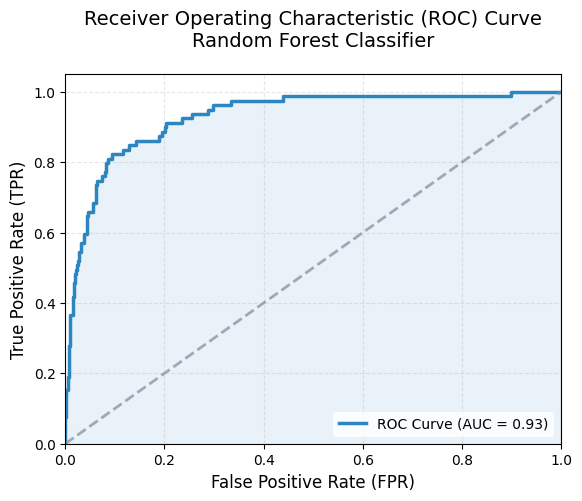

In [ ]:
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#2E86C1', lw=2.5, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#808B96', linestyle='--', lw=2, alpha=0.7)

plt.fill_between(fpr, tpr, alpha=0.1, color='#2E86C1')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve\nRandom Forest Classifier', 
          fontsize=14, pad=20)

plt.legend(loc='lower right', fontsize=10, frameon=True, facecolor='white', edgecolor='none')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

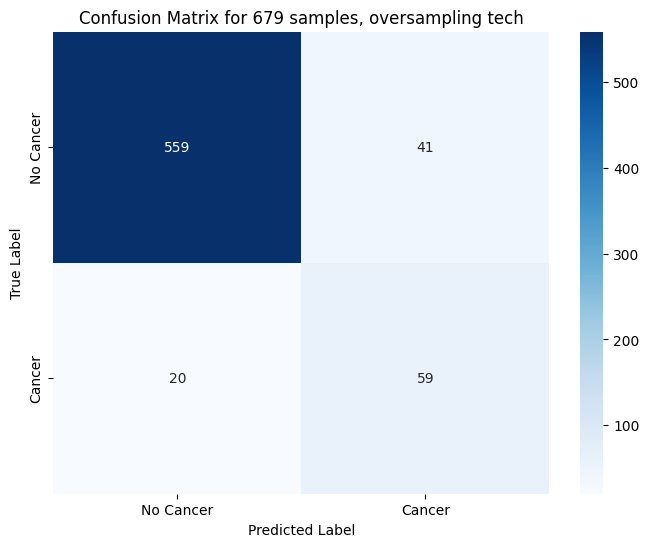

In [328]:
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix for 679 samples, oversampling tech')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

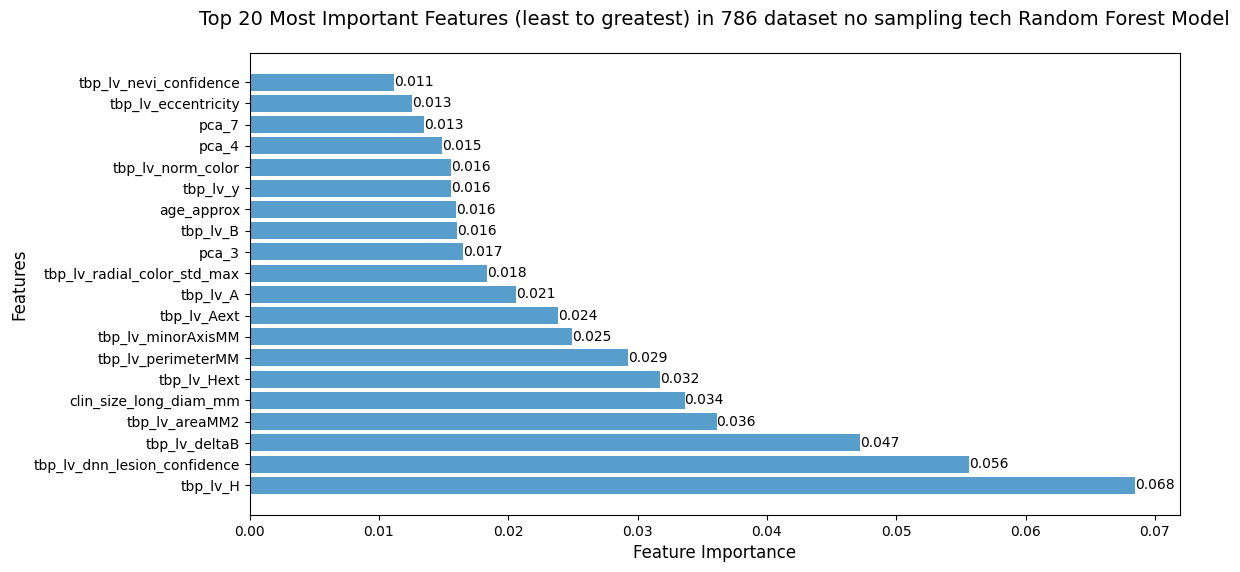

In [ ]:
importance = rf_classifier.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], 
                color='#2E86C1', alpha=0.8)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Most Important Features (least to greatest) in 3393 dataset oversampling tech', 
          fontsize=14, pad=20)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontsize=10)

plt.show()

<bound method NDFrame.head of              isic_id  target  patient_id  age_approx     sex  \
0       ISIC_6973879       0  IP_3201881        55.0  female   
1       ISIC_5407194       0  IP_5714646        40.0    male   
2       ISIC_5273739       0  IP_6391213        85.0    male   
3       ISIC_0802250       0  IP_6611217        55.0    male   
4       ISIC_8084953       0  IP_6957489        70.0    male   
...              ...     ...         ...         ...     ...   
401054  ISIC_6502755       0  IP_7965642        60.0    male   
401055  ISIC_9129069       0  IP_2889176        45.0  female   
401056  ISIC_3342513       0  IP_9577633        50.0    male   
401057  ISIC_3720179       0  IP_3751225        75.0    male   
401058  ISIC_3097113       0  IP_2573038        50.0    male   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
0          lower extremity                    3.15  TBP tile: close-up   
1          posterior torso                    3.03  T

100%|██████████| 786/786 [00:01<00:00, 781.86it/s]



Variance explained by 150 components: 0.9637017257550948
Original class distribution in training set:
target
0    314
1    314
Name: count, dtype: int64

Class distribution after SMOTE:
target
0    314
1    314
Name: count, dtype: int64

Performing 5-fold cross-validation...
Cross-Validation Scores: [0.85714286 0.86507937 0.82539683 0.768      0.848     ]
Mean Accuracy: 0.8327238095238094
Standard Deviation: 0.03498396796553033

Training final model...
Test Set Accuracy: 0.5949367088607594

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        79
           1       0.55      1.00      0.71        79

    accuracy                           0.59       158
   macro avg       0.78      0.59      0.52       158
weighted avg       0.78      0.59      0.52       158



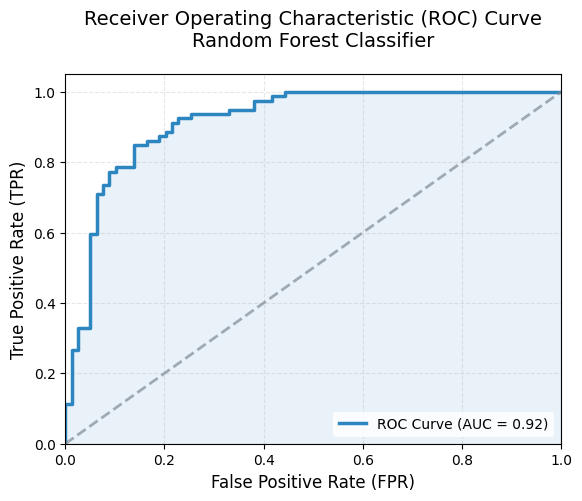

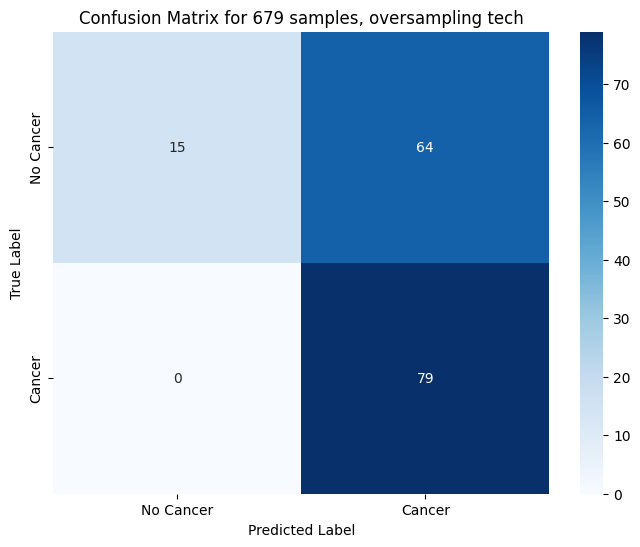

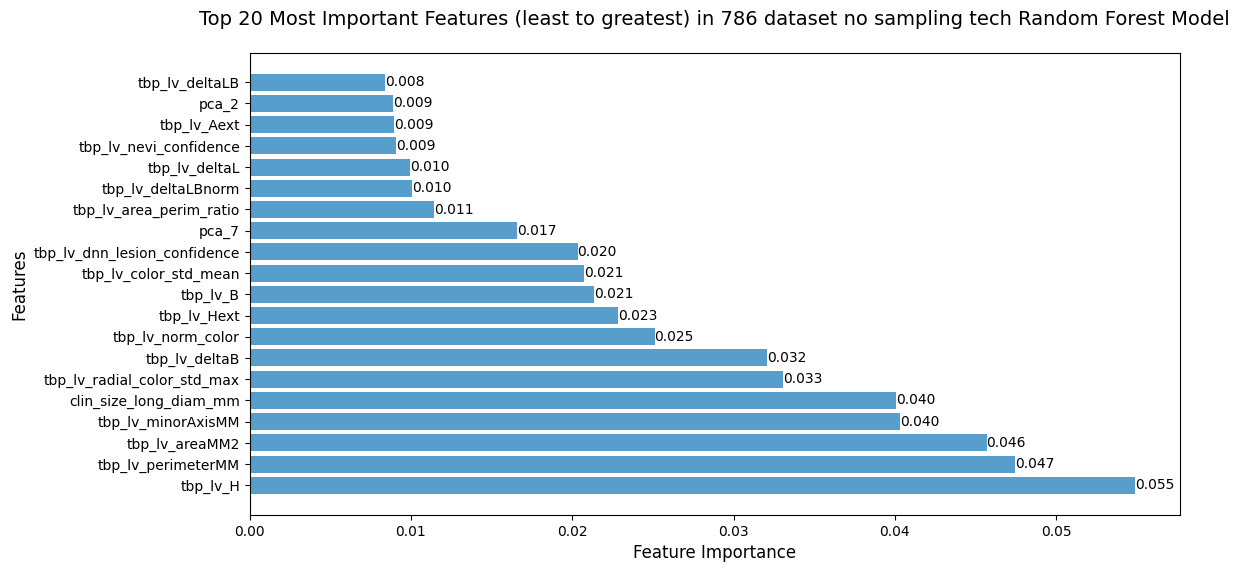

In [330]:
# Random Forest with undersampling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import os
from tqdm import tqdm

df = pd.read_csv("../../data/data/train-metadata.csv", low_memory=False)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head)
benign = df[df['target'] == 0]
malignant  = df[df['target'] == 1]
    
benign_sampled = benign.sample(n=393, random_state=42)
subset_df = pd.concat([benign_sampled, malignant ])
    
print(f"Class 0 samples: {len(benign_sampled)}")
print(f"Class 1 samples: {len(malignant )}")
print(f"Total samples: {len(subset_df)}")
missing_percentages = (subset_df.isnull().sum() / len(subset_df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = subset_df[columns_to_keep]

features_to_drop = [
    'iddx_full',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'patient_id',
    'lesion_id',
    'attribution',
    'copyright_license'
]

# We do this because depending on the seed and shuffle, the columns that get dropped will be different!
for col in features_to_drop:
    if col in skin_cancer_df.columns:
        print(f"Dropping column: {col}")
        skin_cancer_df = skin_cancer_df.drop(columns=[col])

numeric_columns = skin_cancer_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object', 'category']).columns

skin_cancer_df[numeric_columns] = skin_cancer_df[numeric_columns].fillna(
    skin_cancer_df[numeric_columns].median())
skin_cancer_df[categorical_columns] = skin_cancer_df[categorical_columns].fillna(
    skin_cancer_df[categorical_columns].mode().iloc[0])
for col in categorical_columns:
    if col != 'isic_id':
        le = LabelEncoder()
        skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])
expected_samples = len(skin_cancer_df)
image_features = np.zeros((expected_samples, 128 * 128 * 3))
valid_indices = []

for idx, isic_id in tqdm(enumerate(skin_cancer_df['isic_id']), total=expected_samples):
    try:
        file_path = os.path.join("../../data/data/train-image/image", f"{isic_id}.jpg")
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            img_resized = np.array(Image.fromarray(img).resize((128, 128)))
            image_features[idx] = img_resized.reshape(-1)
            valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing {isic_id}: {str(e)}")
        continue

if not valid_indices:
    raise ValueError("No valid images were processed")

image_features = image_features[valid_indices]

image_features_scaled = image_features / 255.0
n_components = 150
pca = PCA(n_components=n_components, random_state=42)
image_features_pca = pca.fit_transform(image_features_scaled)

pca_columns = [f'pca_{i}' for i in range(n_components)]
image_df = pd.DataFrame(image_features_pca, columns=pca_columns)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nVariance explained by {n_components} components: {explained_variance[-1]}")
skin_cancer_df = skin_cancer_df.iloc[valid_indices]
X = pd.concat([
    skin_cancer_df.drop(['isic_id', 'target'], axis=1).reset_index(drop=True),
    image_df
], axis=1)
y = skin_cancer_df['target'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Original class distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index()) 
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    class_weight={0:1, 1:3},
    min_samples_leaf=4,  
    bootstrap=True,
    random_state=42
)
print("\nPerforming 5-fold cross-validation...")
scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")

print("\nTraining final model...")
rf_classifier.fit(X_train, y_train)
y_predict = (rf_classifier.predict_proba(X_test)[:, 1] > 0.2) 
accuracy = accuracy_score(y_test, y_predict)
print(f"Test Set Accuracy: {accuracy}")

print("\nClassification Report:")
print(classification_report(y_test, y_predict))

y_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#2E86C1', lw=2.5, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#808B96', linestyle='--', lw=2, alpha=0.7)

plt.fill_between(fpr, tpr, alpha=0.1, color='#2E86C1')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve\nRandom Forest Classifier', 
          fontsize=14, pad=20)

plt.legend(loc='lower right', fontsize=10, frameon=True, facecolor='white', edgecolor='none')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix for 679 samples, oversampling tech')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

importance = rf_classifier.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], 
                color='#2E86C1', alpha=0.8)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Most Important Features (least to greatest) in 786 dataset no sampling tech Random Forest Model', 
          fontsize=14, pad=20)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontsize=10)

plt.show()